**Importing libraries and loading the data**

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pickle

In [93]:
#Load pre-counted dataframe
final_df = pd.read_csv('../data/interim/final_df.csv')
#final_df.date = pd.to_datetime(final_df.date)

In [94]:
final_df.dropna(axis = 0, subset=["sales_d_1", "sales_d_2", "sales_d_3",
               "sales_month_avg", "sales_week_avg"], inplace=True)

In [95]:
#Modeling - data preparation
final_df = final_df.sort_values(by='date')
final_df.d = final_df.d - final_df.d.min() + 1
final_df = final_df[['item_id',  'store_id',  #categorical - product definition, out because of high correlation - 'state_id', 'cat_id', 'id', 'dept_id',
                     'weekday', 'month', 'event_type', #categorical - time definition and event - sesonality
                     'd',  #trend ,out because of high correlation - 'wm_yr_wk', 'year',
                     'sell_price','sales','turnover',
                     "sales_d_1", "sales_d_2", "sales_d_3",
                      "sales_month_avg"]] # ,"sales_week_avg"

In [96]:
#Make dummy variables (one-hot encoding)
#final_df = pd.get_dummies(final_df, columns=['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','weekday', 'month', 'event_type'], drop_first=False)

final_df = pd.get_dummies(final_df, columns=['item_id', 'store_id', 'weekday', 'month', 'event_type'], drop_first=False)

In [97]:
final_df = final_df.drop(columns=['item_id_HOBBIES_1_049', 'store_id_CA_1', 'weekday_Monday', 'month_January'])

In [98]:
#Dataframe to train+validation and test data
X = final_df.drop(columns=['sales'])
y = final_df.sales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [99]:
turnover_train = X_train.turnover
turnover_test = X_test.turnover

X_train = X_train.drop(columns=['turnover'])
X_test = X_test.drop(columns=['turnover'])

## Modeling

### Baseline model

In [100]:
#Baseline model based on only zeros
y_pred = pd.Series(np.zeros(len(y_test)))
rmse_baseline_sales = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of baseline model for sales is {rmse_baseline_sales}")

rmse_baseline_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred))
print(f"RMSE of baseline model for turnover is {rmse_baseline_turnover}")

RMSE of baseline model for sales is 1.4402969704813904
RMSE of baseline model for turnover is 7.540213610627589


In [104]:
#Baseline model based on average monthly value
y_pred = X_test.sales_month_avg
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of better baseline model is {rmse_baseline}")

rmse_baseline_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred*X_test.sell_price))
print(f"RMSE of better baseline model for turnover is {rmse_baseline_turnover}")

RMSE of better baseline model is 1.07639247619992
RMSE of better baseline model for turnover is 5.342454237117144


### Linear regression

In [57]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_lin = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_lin = pd.DataFrame(X_test_std, columns=X_test.columns)

In [105]:
#Linear Regression model
lin_reg = LinearRegression()

lin_reg.fit(X_train_lin, y_train)
y_pred_lin = lin_reg.predict(X_test_lin)

lin_reg_rmse_sales = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(lin_reg.coef_)

print(f"RMSE of Linear Regression model is {lin_reg_rmse_sales}")

lin_reg_rmse_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred_lin*X_test.sell_price))
print(f"RMSE of Linear Regression model for turnover is {lin_reg_rmse_turnover}")

[-9.14660674e-03 -8.73348678e-02  8.82053258e-02  4.75458162e-02
  3.80077843e-02  4.36364772e-01 -1.99020569e-02 -1.83794836e-02
 -1.82797924e-02 -1.65331694e-02 -1.15650901e-02 -1.32683868e-02
 -1.44152313e-02 -1.30027526e-02 -5.06976186e-03 -9.25769086e-03
  7.05916969e-03 -1.22420759e-02 -1.19368615e-02  2.64822224e-03
  6.42186143e-03 -1.72735797e-02 -1.57517670e-02 -4.73617271e-03
 -1.71092813e-02 -1.61520462e-02 -1.18351457e-02 -8.43569007e-03
 -8.62971586e-04 -1.51673872e-02 -8.04630661e-03 -5.84837584e-03
  1.95184424e-04  4.71729228e-04 -7.10091938e-03 -2.04974277e-02
 -5.14113098e-03  4.29710691e-02 -1.60734629e-02  9.22127480e-04
 -1.39654589e-02 -3.57073773e-03  1.57224096e-02 -1.96427023e-02
 -1.59329559e-02 -2.58020100e-02 -3.24430103e-02 -3.08217772e-02
 -2.27111931e-02 -1.20826681e-02 -2.17465198e-02 -3.19362643e-02
 -2.59603995e-02 -6.61361810e-03 -2.40568115e-02 -1.51405598e-02
 -2.25299523e-02 -1.42378899e-02  4.28871787e-03 -1.67074154e-04
  2.40484211e-02  4.58158

RMSE of Linear Regression model is 1.0668095338285486
RMSE of Linear Regression for turnover is 5.378608013715713


(array([2.01816e+05, 8.81500e+03, 6.74000e+02, 1.06000e+02, 2.70000e+01,
        3.40000e+01, 5.20000e+01, 2.80000e+01, 1.00000e+01, 1.00000e+00]),
 array([ 0.        ,  1.8928717 ,  3.78574339,  5.67861509,  7.57148679,
         9.46435849, 11.35723018, 13.25010188, 15.14297358, 17.03584528,
        18.92871697]),
 <BarContainer object of 10 artists>)

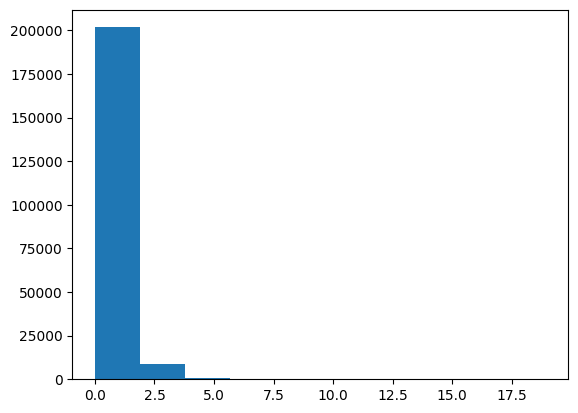

In [106]:
y_pred_lin[y_pred_lin<0] = 0
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(f"RMSE of Linear Regression model is {lin_reg_rmse}")

lin_reg_rmse_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred_lin*X_test.sell_price))
print(f"RMSE of Linear Regression for turnover is {lin_reg_rmse_turnover}")

plt.hist(y_pred_lin)

Importance of features:
Reference category 
 event_type = None 
 weekday = Friday 
 store_id = CA_1 
 dept_id = FOODS_1 



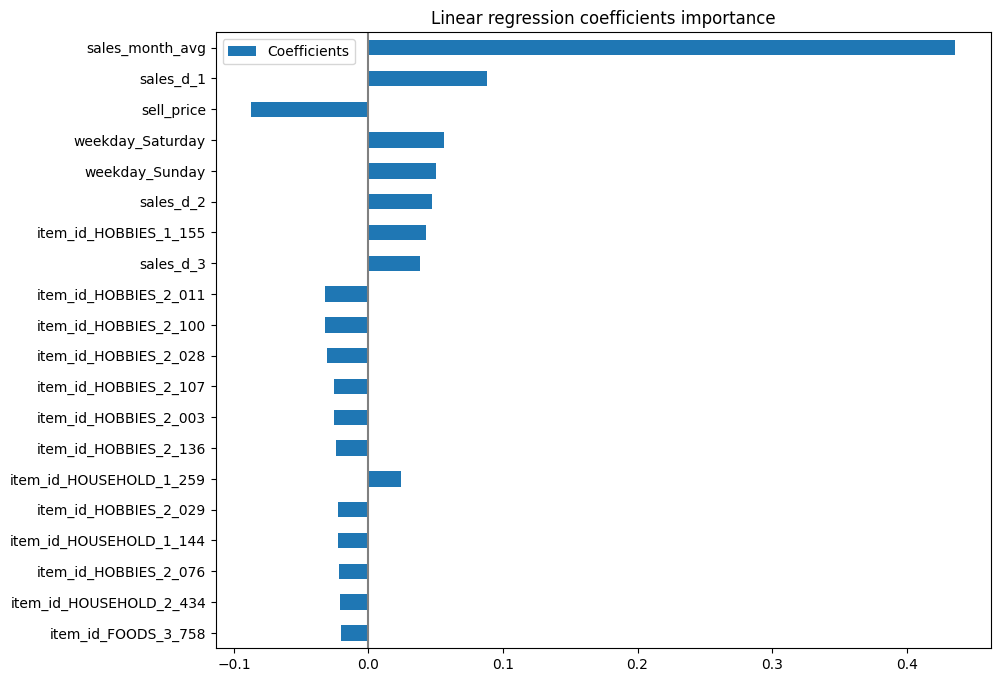

In [116]:
print("Importance of features:")
print("Reference category \n event_type = None \n weekday = Friday \n store_id = CA_1 \n dept_id = FOODS_1 \n")

coefs = pd.DataFrame(lin_reg.coef_, columns=["Coefficients"], index=X_train.columns)
coefs['Absolute_Coefficients'] = coefs['Coefficients'].abs()
coefs = coefs.sort_values(by="Absolute_Coefficients", ascending=True).tail(20)
coefs.drop(columns=["Absolute_Coefficients"], inplace=True)  
coefs.plot(kind="barh", figsize=(10, 8))
plt.axvline(x=0, color=".5")
plt.title('Linear regression coefficients importance')
plt.show()

In [118]:
#Lasso Regression model
sequence = [i / 100.0 for i in range(1, 10)]
sequence.extend([i / 10.0 for i in range(1, 10)])
RMSE_lasso = pd.DataFrame(index=sequence)

for alpha in sequence:
    print(alpha)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    RMSE_lasso.loc[alpha,'RMSE'] = lasso_rmse

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


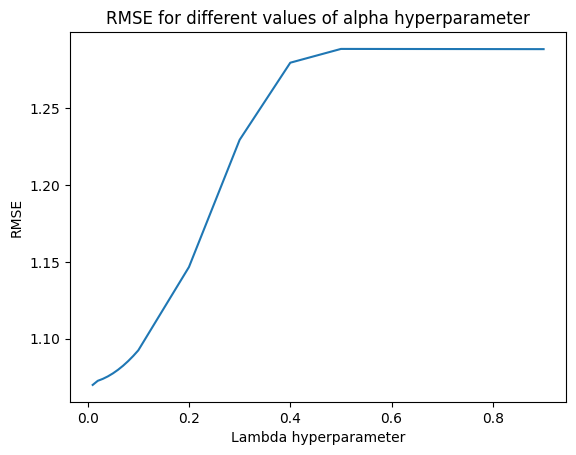

In [119]:
plt.title("RMSE for different values of alpha hyperparameter")
plt.xlabel("Lambda hyperparameter")
plt.ylabel("RMSE")
plt.plot(sequence, RMSE_lasso['RMSE'])

In [69]:
#Lasso Regression model
sequence = [i / 100.0 for i in range(1, 10)]
sequence.extend([i / 10.0 for i in range(1, 10)])
sequence.extend([i / 1.0 for i in range(1, 10)])
sequence.extend([i / 0.1 for i in range(1, 10)])
RMSE_ridge = pd.DataFrame(index=sequence)

for alpha in sequence:
    print(alpha)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    RMSE_ridge.loc[alpha,'RMSE'] = ridge_rmse

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


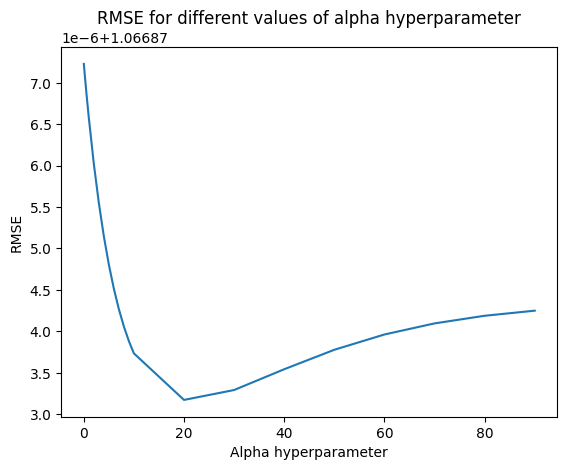

In [70]:
plt.title("RMSE for different values of alpha hyperparameter")
plt.xlabel("Alpha hyperparameter")
plt.ylabel("RMSE")
plt.plot(sequence, RMSE_ridge['RMSE'])

In [103]:
with open('../models/lin_reg_model.pkl', 'wb') as file:
    pickle.dump(lin_reg, file)